In [2]:
!pip install tf_keras_vis -q
!pip install tensorflow_addons -q

     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 12.8 MB/s 


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from operator import itemgetter
import random

import keras
import tensorflow as tf
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, Concatenate
from keras.layers import Conv2D, MaxPooling2D
from sklearn.preprocessing import StandardScaler
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.metrics import accuracy_score, roc_auc_score
from google.colab import files

### Load Dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Innolab")
import data_loader as dtl
from reorder_matrices_regions import reorder_matrices_regions
from viz_utils import ordered_regions
from E2E_conv import E2E_conv

# import nn_modelling_utils as ut

### Preprocessing and preperation for CNN

In [9]:
PATH  = "/content/drive/MyDrive/Colab Notebooks/Innolab/data/GreaterZero/"

#load data from csv
test = pd.read_csv(PATH + "test.csv")
train = pd.read_csv(PATH + "train.csv")

In [10]:
train.head(2)

,ConnID,Repseudonym,siteid,age,visdat,sex,prmdiag,edyears,MEM_score,Apoe,IDs,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,1_1,1_2,1_3,1_4,1_5,1_6,1_7,2_2,2_3,2_4,2_5,2_6,2_7,3_3,3_4,3_5,3_6,3_7,4_4,4_5,4_6,4_7,5_5,5_6,5_7,6_6,6_7,7_7
0,85,3fd91223d,14,63,18.05.2016,1,0,13,1.215577,1.0,85.0,0.666667,0.322021,0.383838,0.352991,0.531469,0.458580,0.459566,0.498575,0.826990,0.612299,0.708824,0.331551,0.650452,0.670814,0.596405,0.916437,0.719192,0.859504,0.531469,0.351981,0.516835,0.748889,0.637879,0.517949,0.660256,0.538889,0.822314,0.416084,0.475524,0.603535,0.704142,0.528107,0.615385,0.778107,0.689103,0.841049
1,11,0f1b4b7ac,11,68,26.10.2017,1,2,13,-0.583224,1.0,11.0,0.785010,0.223228,0.191142,0.364957,0.617716,0.495069,0.670611,0.643162,0.811419,0.815508,0.739216,0.438503,0.566742,0.376697,0.473856,0.966024,0.736364,0.742424,0.424242,0.264569,0.333333,0.700000,0.562121,0.483333,0.462821,0.355556,0.772727,0.559441,0.475524,0.518939,0.704142,0.578402,0.669872,0.724852,0.667735,0.745370


In [11]:
def flat_to_mat_aggregation(x: np.ndarray) -> np.ndarray:
    """
    - converts a flat np.array into a matrix by turning
      the values of the array into a symmetric matrix
    - excluding diagonal

    Args:
         x: 1D array which should be turned into symmetric matrix

    Returns:
         np.ndarray - matrix

    """

    n = len(x)
    n_a = 8
    A = np.zeros(n_a * n_a).reshape(n_a, n_a)
    ind = np.triu_indices(n_a, k=0)
    A[ind] = x
    return A.T + A

In [12]:
def data_augmentation_gaussian(X,X_struc, y, scale = .07):
    X_noise = X.copy()
    X_struc_noise = X_struc.copy()
    y_noise = y.copy()
    
    for i in range(X.shape[0]):
        #add gaussian noise
        noise = np.random.normal(loc = 0, scale = scale, size = (X.shape[1], X.shape[2], 1))
        X_noise[i] = X[i] + np.triu(noise, k=1).reshape(X.shape[1], X.shape[2], 1) + np.triu(noise, k=1).T.reshape(X.shape[1], X.shape[2], 1)

    return np.concatenate((X, X_noise), axis = 0), np.concatenate((X_struc, X_struc_noise), axis = 0), np.concatenate((y, y_noise), axis = 0)

In [13]:
scaler = StandardScaler()
def preprocess_pipeline(df, aggregation = True, train_data = True, augmentation = False, scale = .07):
    
    #create target
    y, X = dtl.preprocess_data(df)
    y = np.array(y, dtype=np.float32)

    X_struc = X[["age", "sex", "edyears"]]


    #drop columns
    cols_to_drop = ["MEM_score", "Apoe", "age", "sex", "edyears"]
    X.drop(columns=cols_to_drop, inplace = True)
    
    #standardize data
    if train_data:
        scaler.fit_transform(X)
    else:
        scaler.transform(X)

    #turn flat array to matrix
    if aggregation:
        n_c = 8
        n_train = len(X)
        X_train_2d = np.zeros(n_train*n_c*n_c).reshape(n_train,n_c,n_c)

        #turn array to matrix
        for i in range(n_train):
            X_train_2d[i] = flat_to_mat_aggregation(X.iloc[i,:])

        stacked = np.stack(X_train_2d, axis = 0)

    else:
        n_c = dtl.flat_to_mat(X.iloc[0,:]).shape[0]
        n_train = len(X)
        X_train_2d = np.zeros(n_train*n_c*n_c).reshape(n_train,n_c,n_c)

        #turn array to matrix
        for i in range(n_train):
            X_train_2d[i] = dtl.flat_to_mat(X.iloc[i,:])

        stacked = np.stack(reorder_matrices_regions(X_train_2d, network = 'yeo7'), axis = 0)

    
    #reshape data
    X_img = stacked.reshape(stacked.shape[0], stacked.shape[1], stacked.shape[2], 1)
    X_struc = X_struc.to_numpy().reshape(stacked.shape[0], 3)


    #add gaussian noise
    if augmentation:
        X_img_aug, X_struc_aug, y_aug  = data_augmentation_gaussian(X_img, X_struc, y, scale=scale)
        return X_img_aug, X_struc_aug, y_aug
    else:
        return X_img, X_struc, y 

In [14]:
X_train, X_train_struc, y_train = preprocess_pipeline(train, train_data = True, augmentation = False)
X_test, X_test_struc, y_test = preprocess_pipeline(test, train_data = False, augmentation = False)

In [15]:
print(X_train.shape)
print(X_train_struc.shape)

(385, 8, 8, 1)
(385, 3)


In [29]:
X_aug, X_aug_struc, y_aug = preprocess_pipeline(train, train_data = True, augmentation = True, scale = 0.0625)

In [30]:
print(X_aug.shape)
print(X_aug_struc.shape)

(770, 8, 8, 1)
(770, 3)


In [31]:
# Train val split
shuffled_indices = list(range(len(X_aug)))
random.shuffle(shuffled_indices)

train_idxs = shuffled_indices[:500]
val_idxs = shuffled_indices[500:]

val_x = X_aug[val_idxs]
val_x_struc = X_aug_struc[val_idxs]
val_y = y_aug[val_idxs]

train_x = X_aug[train_idxs]
train_x_struc = X_aug_struc[train_idxs]
train_y = y_aug[train_idxs]

In [32]:
## TODO: Implement CCNN https://www.researchgate.net/publication/318652568_Resting_State_fMRI_Functional_Connectivity-Based_Classification_Using_a_Convolutional_Neural_Network_Architecture/link/5978a095aca27203ecc4a2a1/download 

### Models

In [61]:
def brain_net_cnn(input_dim_img, input_dim_struc, output_dim: int = 1, kernel_regularizer  = keras.regularizers.l2(0.0005),
                  kernel_initializer = 'he_uniform', dropout_rate = 0.5, opt = Adam(), loss = "binary_crossentropy"):
    
    #Source: https://kawahara.ca/convolutional-neural-networks-for-adjacency-matrices/
    input_img = Input(shape=input_dim_img, name='input_img')

    x = E2E_conv(rank = 2, filters = 32, kernel_size = (2,input_dim_img[0]),kernel_regularizer=kernel_regularizer, input_shape=(input_dim_img[0],input_dim_img[1],input_dim_img[2]),
                 activation=LeakyReLU(alpha=0.33),data_format="channels_last")(input_img)

    x = E2E_conv(rank = 2, filters = 32, kernel_size = (2,input_dim_img[0]),kernel_regularizer=kernel_regularizer, input_shape=(input_dim_img[0],input_dim_img[1],input_dim_img[2]),
                 activation=LeakyReLU(alpha=0.33),data_format="channels_last")(x)

    x = Conv2D(filters=64, kernel_size=(1, input_dim_img[0]), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33), name='Edge-to-Node')(x)

    x = Conv2D(filters=64, kernel_size=(input_dim_img[1], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33), name='Node-to-Graph')(x)

    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)

    #add strutural data such as age, etc.
    input_struc = Input(shape=input_dim_struc, name='input_struc')

    x = Concatenate(axis = -1)([x,input_struc])

    x = Dense(128,kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33))(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128,kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33))(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(output_dim, activation="sigmoid")(x)

    #compile model
    model = Model(inputs=[input_img, input_struc], outputs=out)
    
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

In [62]:
def ccnn_model_with_struc(input_dim_img, input_dim_struc, output_dim: int = 1, kernel_regularizer  = keras.regularizers.l2(0.0005),
                          kernel_initializer = 'he_uniform', dropout_rate = 0.5, opt = Adam(), loss = "binary_crossentropy"):

    input_img = Input(shape=input_dim_img, name='input_img')

    #add strutural data such as age, etc.
    input_struc = Input(shape=input_dim_struc, name='input_struc')

    # create model
    x = Conv2D(filters=64, kernel_size=(1, input_dim_img[0]), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33), name='Edge-to-Node')(input_img)

    x = Conv2D(filters=64, kernel_size=(input_dim_img[1], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33), name='Node-to-Graph')(x)

    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)

    x = Concatenate(axis = -1)([x,input_struc])

    x = Dense(128,kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33))(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128,kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33))(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(output_dim, activation="sigmoid")(x)


    #compile model
    model = Model(inputs=[input_img, input_struc], outputs=out)
    
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

In [63]:
def ccnn_model(input_dim, output_dim: int = 1, opt = Adam(), loss = "binary_crossentropy"):

    filter_num1 = 64
    filter_num2 = 128 

    # create model
    input = Input(shape=input_dim, name='input')
    x = Conv2D(filters=filter_num1, kernel_size=(input_dim[0], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_initializer='he_uniform', activation='relu', name='conv1')(input)
    x = Dropout(0.6)(x)
    x = Conv2D(filters=filter_num2, kernel_size=(1, input_dim[1]), strides=(1, 1),
                                  padding='valid',
                                  kernel_initializer='he_uniform', activation='relu', name='conv2')(x)
    x = Dropout(0.6)(x)
    
    # x = Conv2D(filters=filter_num1, kernel_size=(5, 5), strides=(1, 1),
    #                               padding='valid',
    #                               kernel_initializer='he_uniform', activation='relu', name='conv1')(input)
    # x = Conv2D(filters=filter_num2, kernel_size=(3, 3), strides=(1, 1),
    #                               padding='valid',
    #                               kernel_initializer='he_uniform', activation='relu', name='conv2')(x)

    x = Flatten()(x)


    #dense part of the network
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.6)(x)
    out = Dense(output_dim, activation="sigmoid")(x)

    model = Model(inputs=[input], outputs=out)
    #model = Model(inputs=[first_input, second_input], outputs=out)
    model.compile(loss=loss,
                  optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

In [81]:
def test_model(input_dim_img, output_dim: int = 1, kernel_regularizer  = keras.regularizers.l2(0.0005),
               kernel_initializer = 'he_uniform', dropout_rate = 0.5, opt = Adam(), loss = "binary_crossentropy"):

    input_img = Input(shape=input_dim_img, name='input_img')

    x = E2E_conv(rank = 2, filters = 32, kernel_size = (2,input_dim_img[0]),kernel_regularizer=kernel_regularizer, input_shape=(input_dim_img[0],input_dim_img[1],input_dim_img[2]),
                 activation=LeakyReLU(alpha=0.33),data_format="channels_last")(input_img)

    x = E2E_conv(rank = 2, filters = 32, kernel_size = (2,input_dim_img[0]),kernel_regularizer=kernel_regularizer, input_shape=(input_dim_img[0],input_dim_img[1],input_dim_img[2]),
                 activation=LeakyReLU(alpha=0.33),data_format="channels_last")(x)

    x = Conv2D(filters=64, kernel_size=(1, input_dim_img[0]), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33), name='Edge-to-Node')(x)

    x = Conv2D(filters=64, kernel_size=(input_dim_img[1], 1), strides=(1, 1),
                                  padding='valid',
                                  kernel_regularizer=kernel_regularizer,
                                  kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33), name='Node-to-Graph')(x)

    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)

    x = Dense(128,kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33))(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128,kernel_initializer=kernel_initializer, activation=LeakyReLU(alpha=0.33))(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(output_dim, activation="sigmoid")(x)

    #compile model
    model = Model(inputs=input_img, outputs=out)
    
    model.compile(loss=loss,
                  optimizer=opt,
                  metrics=[tf.keras.metrics.BinaryAccuracy(),
                          tf.keras.metrics.FalseNegatives()])
  
    return model

### Training

In [73]:
batch_size = 32
epochs = 100
lr = 0.001
opt = AdamW(learning_rate = lr, weight_decay = 0.001)
input_shape_2d = (X_aug.shape[1], X_aug.shape[2], 1)
input_struc_dim = (X_aug_struc.shape[1])

In [66]:
X_aug.shape

(770, 8, 8, 1)

In [82]:
ccnn = ccnn_model(input_dim = input_shape_2d, output_dim = 1, opt = opt)
ccnn_with_struc = ccnn_model_with_struc(input_dim_img = input_shape_2d, input_dim_struc = input_struc_dim, output_dim = 1, opt = opt)
brainnetcnn = brain_net_cnn(input_dim_img = input_shape_2d, input_dim_struc = input_struc_dim, output_dim = 1, opt = opt)
test = test_model(input_dim_img = input_shape_2d, output_dim = 1, opt = opt)

print(ccnn.summary())
print(ccnn_with_struc.summary())
print(brainnetcnn.summary())
print(test.summary)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 8, 8, 1)]         0         
                                                                 
 conv1 (Conv2D)              (None, 1, 8, 64)          576       
                                                                 
 dropout_42 (Dropout)        (None, 1, 8, 64)          0         
                                                                 
 conv2 (Conv2D)              (None, 1, 1, 128)         65664     
                                                                 
 dropout_43 (Dropout)        (None, 1, 1, 128)         0         
                                                                 
 flatten_14 (Flatten)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               165

In [77]:
train_2d = tf.data.Dataset.from_tensor_slices((train_x, train_x_struc, train_y))
#train_2d = tf.data.Dataset.from_tensor_slices((train_x, train_y))

SHUFFLE_BUFFER_SIZE = 100

train_2d_batch = train_2d.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)

In [78]:
train_x.shape

(500, 8, 8, 1)

In [79]:
train_x_struc.shape

(500, 3)

In [152]:
brainnet_fit = brainnetcnn.fit([train_x, train_x_struc], train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=([val_x, val_x_struc], val_y))

Epoch 1/100
16/16 [==============================] - 2s 28ms/step - loss: 8.6940 - binary_accuracy: 0.5060 - false_negatives_15: 116.0000 - val_loss: 1.1985 - val_binary_accuracy: 0.4778 - val_false_negatives_15: 140.0000
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 5.9247 - binary_accuracy: 0.4820 - false_negatives_15: 134.0000 - val_loss: 0.7766 - val_binary_accuracy: 0.6667 - val_false_negatives_15: 49.0000
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 2.9099 - binary_accuracy: 0.5320 - false_negatives_15: 108.0000 - val_loss: 0.8007 - val_binary_accuracy: 0.6296 - val_false_negatives_15: 34.0000
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 2.0673 - binary_accuracy: 0.5220 - false_negatives_15: 129.0000 - val_loss: 0.8111 - val_binary_accuracy: 0.6111 - val_false_negatives_15: 92.0000
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 1.6213 - binary_accuracy: 0.4900 - false_neg

In [76]:
cnn_with_struc_fit = ccnn_with_struc.fit([train_x, train_x_struc], train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=([val_x, val_x_struc], val_y))

Epoch 1/100
16/16 [==============================] - 0s 6ms/step - loss: 0.6401 - binary_accuracy: 0.6540 - false_negatives_8: 86.0000 - val_loss: 0.5884 - val_binary_accuracy: 0.6852 - val_false_negatives_8: 24.0000
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6304 - binary_accuracy: 0.6520 - false_negatives_8: 84.0000 - val_loss: 0.5935 - val_binary_accuracy: 0.6815 - val_false_negatives_8: 13.0000
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6360 - binary_accuracy: 0.6440 - false_negatives_8: 41.0000 - val_loss: 0.6366 - val_binary_accuracy: 0.6370 - val_false_negatives_8: 87.0000
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6314 - binary_accuracy: 0.6660 - false_negatives_8: 105.0000 - val_loss: 0.5902 - val_binary_accuracy: 0.6963 - val_false_negatives_8: 21.0000
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6177 - binary_accuracy: 0.6820 - false_negatives_8: 68.0

In [83]:
test_fit = test.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y))

Epoch 1/100
16/16 [==============================] - 3s 44ms/step - loss: 0.9375 - binary_accuracy: 0.4760 - false_negatives_16: 124.0000 - val_loss: 0.8251 - val_binary_accuracy: 0.5667 - val_false_negatives_16: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.8602 - binary_accuracy: 0.5080 - false_negatives_16: 108.0000 - val_loss: 0.8157 - val_binary_accuracy: 0.5704 - val_false_negatives_16: 2.0000
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.8488 - binary_accuracy: 0.5020 - false_negatives_16: 102.0000 - val_loss: 0.8231 - val_binary_accuracy: 0.4333 - val_false_negatives_16: 153.0000
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.8171 - binary_accuracy: 0.5160 - false_negatives_16: 118.0000 - val_loss: 0.8084 - val_binary_accuracy: 0.6741 - val_false_negatives_16: 48.0000
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8255 - binary_accuracy: 0.4760 - false

In [ ]:
#standard_cnn_fit = standard_cnn.fit(train_2d_batch, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(val_x, val_y))

### Evaluation

In [153]:
y_pred = np.round(brainnetcnn.predict([X_test, X_test_struc]))

In [154]:
accuracy_score(y_test, y_pred)

0.6823529411764706

In [155]:
roc_auc_score(y_test, y_pred)

0.700168918918919

### Save Model

In [170]:
#!mkdir -p saved_model
brainnetcnn.save('saved_model/brainnetcnn_v1') 

INFO:tensorflow:Assets written to: saved_model/brainnetcnn_v1/assets


INFO:tensorflow:Assets written to: saved_model/brainnetcnn_v1/assets


### Visualization

In [162]:
model_viz = tf.keras.models.load_model('saved_model/brainnetcnn_v1')
#model = ccnn_with_struc

In [167]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

def score_function(output):
    # The `output` variable refers to the output of the model,
    return [i[0] for i in output]
    #return (output[0][0], output[1][0], output[2][0] )

In [172]:
def average_feature_map(model, X, y, method = 'saliency'):
    
    #replace last layer with linear layer
    replace2linear = ReplaceToLinear()

    if method == 'saliency':
        cam = Saliency(model,
                       model_modifier=replace2linear,
                       clone=True)
        
        feature_map = cam(score_function,
                          X)

    elif method == 'gradcam':
        # Create Gradcam object
        cam = Gradcam(model,
                      model_modifier=replace2linear,
                      clone=True)
        
        # Generate heatmap with GradCAM
        feature_map = cam(score_function,
                          X,
                          penultimate_layer=-1)        

    elif method == 'gradcamplus':
        cam = GradcamPlusPlus(model,
                              model_modifier=replace2linear,
                              clone=True)
        # Generate heatmap with GradCAM++
        feature_map = cam(score_function,
                          X,
                          penultimate_layer=-1)
    
    figs = []
    #create visualization
    for label in [0,1]:
        
        y_ind = [i for i, x in enumerate(y) if x==label]

        if label ==1:
            title = "Has Alzheimer"
        else:
            title = "No Alzheimer"

        heatmap = feature_map[0][y_ind].mean(axis = 0)


        fig, ax = plt.subplots(figsize=(10, 10))
        plt.imshow(heatmap, cmap='gist_heat_r')
        plt.colorbar()
        ax.set_xticks([0,1,2,3,4,5,6,7])
        ax.set_yticks([0,1,2,3,4,5,6,7])
        ax.set_xticklabels(ticklabel)
        ax.set_yticklabels(ticklabel)

        plt.hlines([0.5,1.5,2.5,3.5,4.5,5.5,6.5],-0.5,7.5,linewidth = 2)
        plt.vlines([0.5,1.5,2.5,3.5,4.5,5.5,6.5],-0.5,7.5,linewidth = 2)
        plt.title(title)
        plt.tight_layout()

        figs.append(fig)
        plt.close()

    return figs

In [173]:
average_maps = average_feature_map(model = brainnetcnn,
                                   X = [tf.cast(X_train, dtype=tf.float32), tf.cast(X_train_struc, dtype=tf.float32)],
                                   y = y_train,
                                   method = 'saliency')

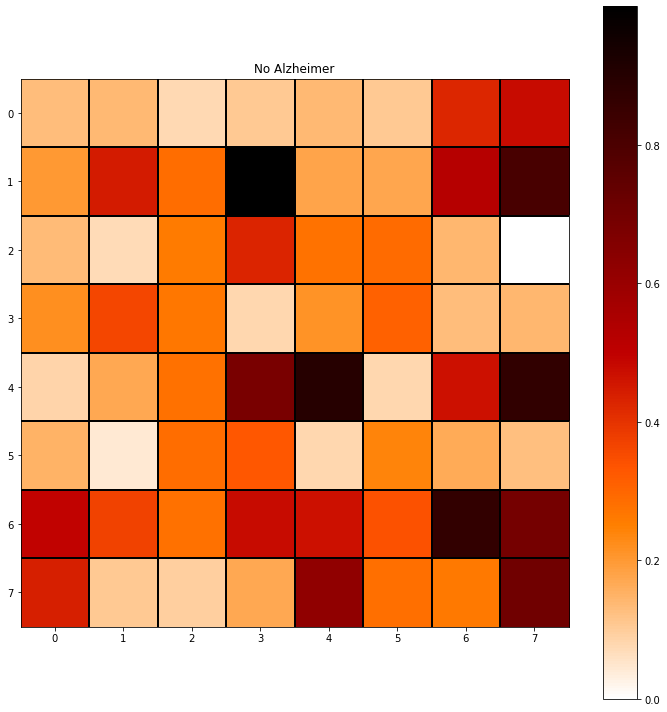

In [174]:
average_maps[0]

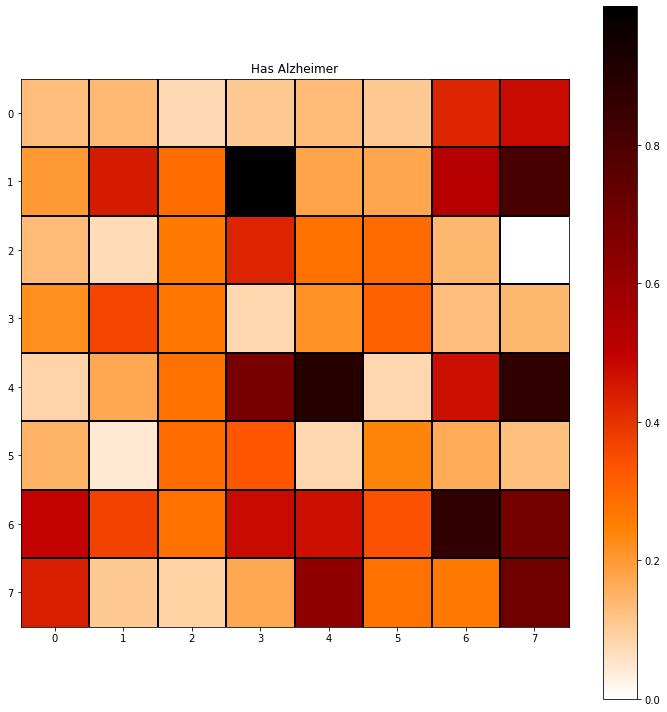

In [175]:
average_maps[1]

In [176]:
average_maps[0].savefig('No_Alzheimer_average_Brainnet_cnn.png', dpi=average_maps[0].dpi)
average_maps[1].savefig('Has_Alzheimer_average_Brainnet_cnn.png', dpi=average_maps[1].dpi)

### Visualizations helpers

In [ ]:
replace2linear = ReplaceToLinear()

In [100]:
ordered_roi, ordered_region = ordered_regions()

In [101]:
ordered_region = list(map(int, ordered_region))

In [102]:
hlines = []
for i in range(len(ordered_region)-1):
    if ordered_region[i] < ordered_region[i+1]:
      hlines.append(i)

In [103]:
temp = hlines
temp.append(245)
temp.insert(0,0)
ticks = []
for i in range(len(temp)-1):
    ticks.append(np.round(np.mean([temp[i], temp[i+1]])))

In [104]:
ticklabel = ["0","1","2","3","4","5","6","7"]

### Saliency Map

In [ ]:
from tf_keras_vis.saliency import Saliency
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

In [113]:
X_train[0:3].shape

(3, 8, 8, 1)

In [114]:
# Generate saliency map
saliency_map = saliency(score_function, [tf.cast(X_train[0:3], dtype=tf.float32), tf.cast(X_train_struc[0:3], dtype=tf.float32)])

In [124]:
saliency_map[0][1].shape

(8, 8)

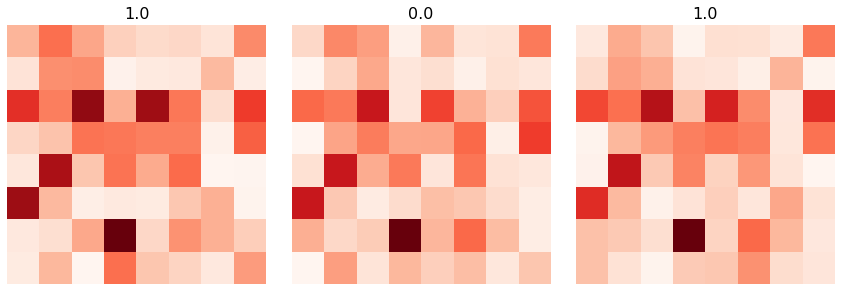

In [126]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(y_test[0:3]):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[0][i], cmap='Reds')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

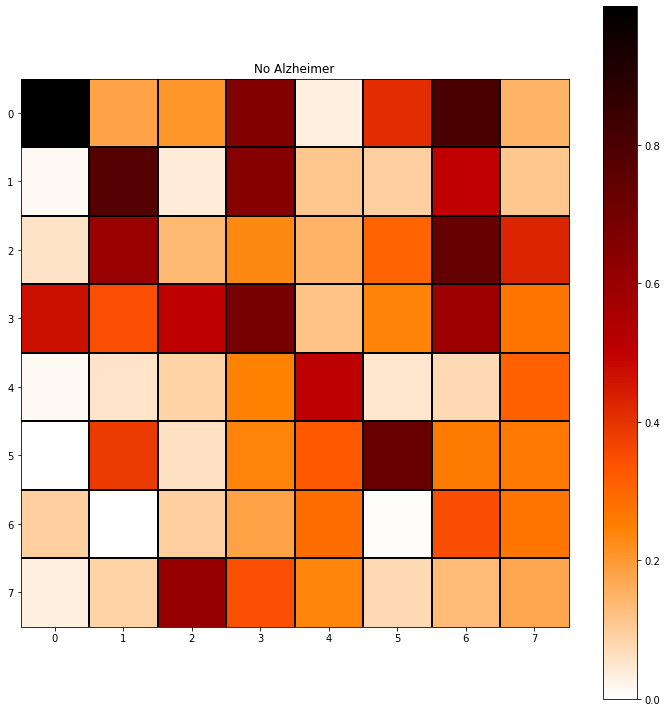

In [ ]:
i = 252
X = X_train[i]
y = y_train[i]

if y ==1:
    title = "Has Alzheimer"
else:
    title = "No Alzheimer"
saliency_map = saliency(score_function, X)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(saliency_map[0], cmap='gist_heat_r')
plt.colorbar()
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_yticks([0,1,2,3,4,5,6,7])
ax.set_xticklabels(ticklabel)
ax.set_yticklabels(ticklabel)

plt.hlines([0.5,1.5,2.5,3.5,4.5,5.5,6.5],-0.5,7.5,linewidth = 2)
plt.vlines([0.5,1.5,2.5,3.5,4.5,5.5,6.5],-0.5,7.5,linewidth = 2)
plt.title(title)
plt.tight_layout()

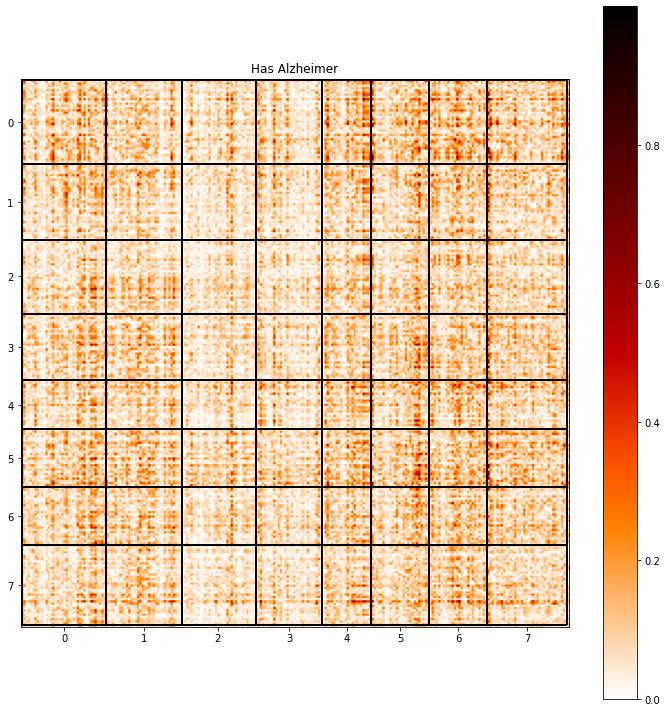

In [ ]:
i = 252
X = X_train[i]
y = y_train[i]

if y ==1:
    title = "Has Alzheimer"
else:
    title = "No Alzheimer"
saliency_map = saliency(score_function, X)

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(saliency_map[0], cmap='gist_heat_r')
plt.colorbar()
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticklabel)
ax.set_yticklabels(ticklabel)

plt.hlines(hlines,0,245,linewidth = 2)
plt.vlines(hlines,0,245,linewidth = 2)
plt.title(title)
plt.tight_layout()

In [ ]:
if y ==1:
    fig.savefig('Alzheimer_' + str(i) + '.png', dpi=fig.dpi)
else:
    fig.savefig('No_Alzheimer_' + str(i) + '.png', dpi=fig.dpi)

### Grad Cam

In [ ]:
# Create Gradcam object
gradcam = Gradcam(ccnn,
                  model_modifier=replace2linear,
                  clone=True)


In [ ]:
# Generate heatmap with GradCAM
cam = gradcam(score_function,
              X,
              penultimate_layer=-1)

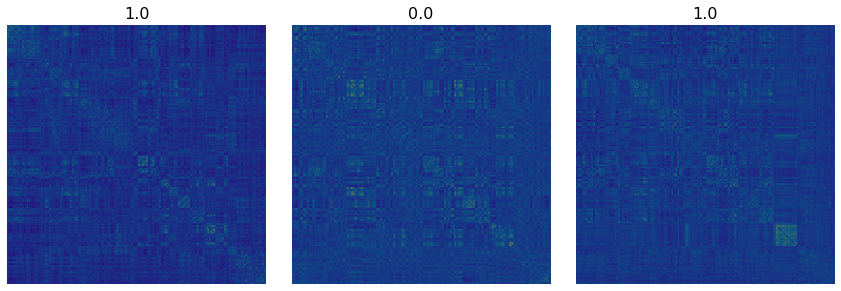

In [ ]:
# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(y_train[0:3]):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(X[i].reshape((246,246)))
    ax[i].imshow(cam[i], cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()

(246, 246)

### Grad Cam ++

In [ ]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
gradcam = GradcamPlusPlus(model,
                          model_modifier=replace2linear,
                          clone=True)

In [ ]:
# Generate heatmap with GradCAM++
cam = gradcam(score_function,
              X,
              penultimate_layer=-1)


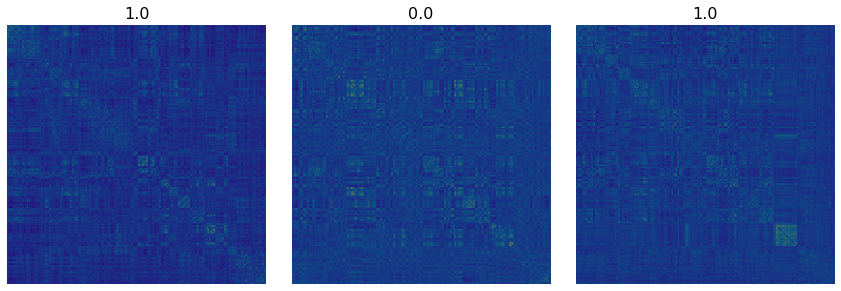

In [ ]:
# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(y_train[0:3]):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(X[i].reshape((246,246)))
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()